In [1]:
import pandas as pd
import os
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sentence_transformers import SentenceTransformer
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)

nlp = spacy.load("en_core_web_lg")

/opt/anaconda3/envs/nlp_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cleaned_courses = pd.read_pickle('../data/cleaned_courses.pkl')

In [3]:
##Keywords related with AI manually selected. This keywords are the result of:
# 1) individual and group brainstorm,
# 2) Wikipedia inputs on Artificial intelligence (https://en.wikipedia.org/wiki/Artificial_intelligence#History)
# 3) CoPilot inputs
AI_orig = [
        "Turing",
        "Turing machine",
        "Logic theorist",
        "Evolutionary computation",
        "Computational",
        "Computer vision",
        "Thinking Machines",
        "Symbolic reasoning",
        "Cellular Automata",
        "Cognitive revolution",
        "AI",
        "Artificial Intelligence",
        "Computational Intelligence",
        "Algorithm",
        "Machine Learning",
        "ML",
        "Supervised learning",
        "Unsupervised learning",
        "Semi-supervised learning",
        "Reinforcement learning",
        "Deep learning",
        "Neural networks",
        "Bayesian Networks",
        "Evolutionary Computation",
        "Natural language processing",
        "Data Science",
        "Computational Social Science",
        "Network Science",
        "Large Language Models",
    ]
AI = sorted(AI_orig)

In [4]:
# cleaned_courses.info()
duplicate_mask = cleaned_courses.duplicated(subset=['Description'], keep=False)
repeating_values_df = cleaned_courses[duplicate_mask]
test = repeating_values_df[repeating_values_df['Description'] == 'This course is not described in the text.'].copy()
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83 entries, 1 to 4693469
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ipeds_id           83 non-null     object
 1   cat_type           83 non-null     object
 2   start_yr           83 non-null     int64 
 3   end_yr             83 non-null     int64 
 4   page_num           83 non-null     int64 
 5   col_num            83 non-null     int64 
 6   type               83 non-null     object
 7   annote_id          83 non-null     int64 
 8   Department         83 non-null     object
 9   Number             83 non-null     object
 10  Title              83 non-null     object
 11  Description        83 non-null     object
 12  Prerequisites      83 non-null     object
 13  Credits            83 non-null     object
 14  Teacher            83 non-null     object
 15  decade             83 non-null     int64 
 16  quinquennium       83 non-null     int64 
 17 

In [5]:
## Preprocessing functions to apply to catalogs' aggregated course descriptions
def remove_double_spaces(text):
    if not text:
        return ""
    return " ".join(text.split())


def remove_paragraphs_dash(text):
    return re.sub(r"-\n", "", text)


def remove_paragraphs(text):
    return re.sub("\n", " ", text)

In [6]:
uvm = cleaned_courses[cleaned_courses['ipeds_id'] == '231174'].copy()
ucla = cleaned_courses[cleaned_courses['ipeds_id'] == '110662'].copy()
und = cleaned_courses[cleaned_courses['ipeds_id'] == '200280'].copy()

# concat dataframes
selected_universities = pd.concat([uvm, ucla, und], ignore_index=True)
selected_universities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899681 entries, 0 to 899680
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ipeds_id           899681 non-null  object
 1   cat_type           899681 non-null  object
 2   start_yr           899681 non-null  int64 
 3   end_yr             899681 non-null  int64 
 4   page_num           899681 non-null  int64 
 5   col_num            899681 non-null  int64 
 6   type               899681 non-null  object
 7   annote_id          899681 non-null  int64 
 8   Department         899681 non-null  object
 9   Number             899681 non-null  object
 10  Title              899681 non-null  object
 11  Description        899681 non-null  object
 12  Prerequisites      899681 non-null  object
 13  Credits            899681 non-null  object
 14  Teacher            899681 non-null  object
 15  decade             899681 non-null  int64 
 16  quinquennium       8

In [7]:
test = und[und['start_yr'] == 1886].copy()
test


,ipeds_id,cat_type,start_yr,end_yr,page_num,col_num,type,annote_id,Department,Number,Title,Description,Prerequisites,Credits,Teacher,decade,quinquennium,DepartmentCleaned
4277411,200280,both,1886,1887,22,0,courses,815186,Math,23,Scientific Course,"LOGIC, -One hour.",,,"{'Honorific': '', 'Name': '', 'Degree': '', 'P...",1880,1885,mathematics


In [8]:
# Combine Title and Description for each course
# Handle missing values by filling with empty strings
selected_universities['combined_text'] = (
    selected_universities['Title'].fillna('') + ' ' + 
    selected_universities['Description'].fillna('')
)

# Apply preprocessing
courses_content = (
    selected_universities['combined_text']
    .apply(remove_double_spaces)
    .apply(remove_paragraphs)
    .apply(remove_paragraphs_dash)
    .to_numpy()
)

In [9]:
model = SentenceTransformer("all-MiniLM-L6-v2")
X = model.encode(courses_content)


In [10]:
query_vec = model.encode(AI_orig)

# Calculate cosine similarity between AI keywords and courses
similarities = cosine_similarity(query_vec, X)

# Create dataframe with similarities
df_similarities = pd.DataFrame(
    data=similarities.T,  # Transpose so rows=courses, columns=AI keywords
    columns=AI_orig
)

# Add back the course metadata - FIXED: Use df_similarities instead of selected_universities
df_results = pd.concat([
    selected_universities[['ipeds_id', 'cat_type', 'start_yr', 'end_yr', 
                'Department', 'DepartmentCleaned', 'Number', 'Title', 
                'Description', 'decade', 'quinquennium']].reset_index(drop=True),
    df_similarities.reset_index(drop=True) 
], axis=1)

# Melt to long format
df_overall = df_results.melt(
    id_vars=['ipeds_id', 'cat_type', 'start_yr', 'end_yr', 
             'Department', 'DepartmentCleaned', 'Number', 'Title', 
             'Description', 'decade', 'quinquennium'],
    value_vars=AI_orig,
    var_name='AI_word',
    value_name='cos'
)

# Create start_end_year column for plotting
df_overall['start_end_year'] = df_overall['start_yr'].astype(str) + '_' + df_overall['end_yr'].astype(str)

In [11]:
# Aggregate to catalog level
df_catalog_agg = df_overall.groupby(
    ['ipeds_id', 'cat_type', 'start_yr', 'end_yr', 'start_end_year', 'AI_word']
).agg({
    'cos': ['mean', 'max', 'count']
}).reset_index()

df_catalog_agg.columns = ['ipeds_id', 'cat_type', 'start_yr', 'end_yr', 
                          'start_end_year', 'AI_word', 'cos_mean', 'cos_max', 'num_courses']

# Choose which metric to use (mean or max)
df_catalog_agg['cos'] = df_catalog_agg['cos_mean']  # or use cos_max
use_threshold = True  # toggle this
threshold = 0.6
if use_threshold:
    df_90pp_final = df_catalog_agg[df_catalog_agg['cos'] >= threshold].copy()
else:
    df_90pp_final = df_catalog_agg.copy()

cos_values = df_90pp_final['cos'].dropna()
if cos_values.empty:
    vmin, vmax = 0.0, 1.0
else:
    vmin, vmax = cos_values.min(), cos_values.max()
# Check what you have
print(f"Catalog aggregations: {len(df_catalog_agg)}")
print(f"Unique catalogs: {df_catalog_agg.groupby(['ipeds_id', 'cat_type', 'start_yr', 'end_yr']).ngroups}")

Catalog aggregations: 11194
Unique catalogs: 386


Color scale: 0 to 9 courses per keyword


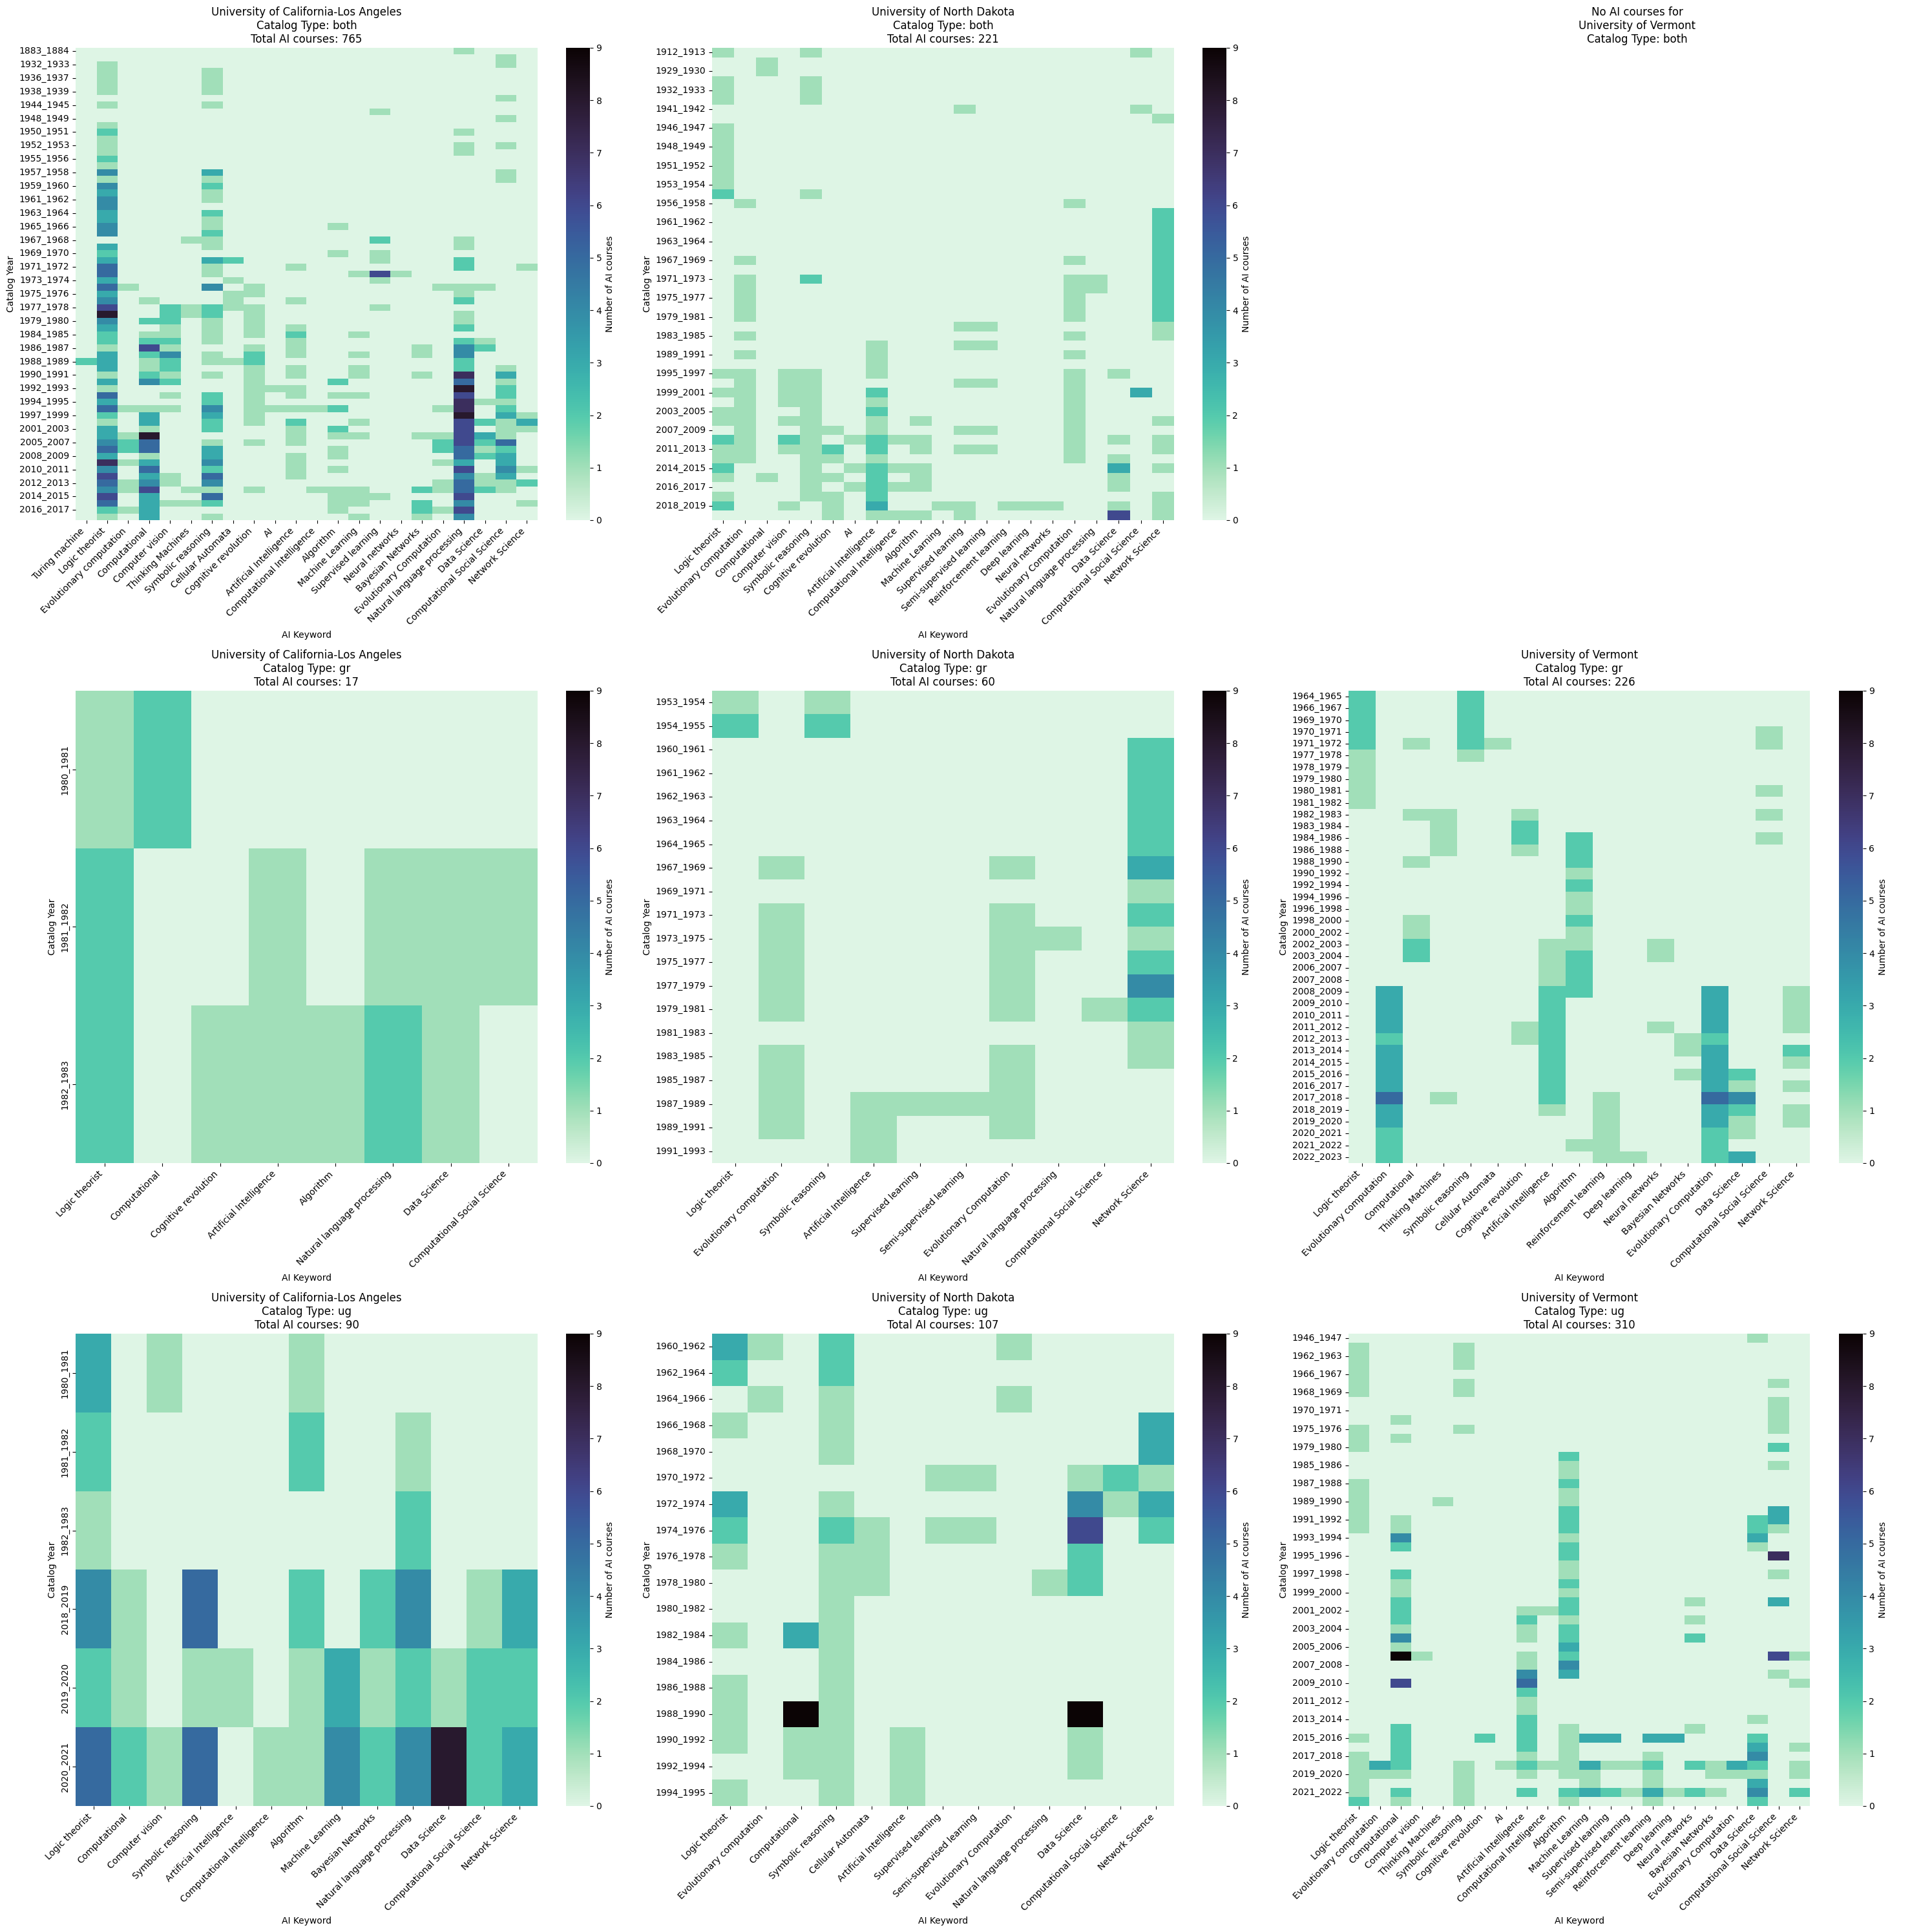

In [12]:
# Create keyword-level counts per catalog
# For each catalog and keyword, count courses above threshold
# Restore robust map_ipeds_name dictionary
map_ipeds_name = {
    "110662": "University of California-Los Angeles",
    "200280": "University of North Dakota",
    "231174": "University of Vermont",
    # Add more ipeds_id:name pairs here as needed
}
df_keyword_counts = df_overall[df_overall['cos'] >= threshold].groupby(
    ['ipeds_id', 'cat_type', 'start_yr', 'end_yr', 'start_end_year', 'AI_word']
).agg({
    'cos': 'count'  # Count courses above threshold for each keyword
}).reset_index()

df_keyword_counts.columns = ['ipeds_id', 'cat_type', 'start_yr', 'end_yr', 
                              'start_end_year', 'AI_word', 'num_courses']

# Set consistent color scale limits
vmin = 0
vmax = df_keyword_counts['num_courses'].max()

print(f"Color scale: {vmin} to {vmax} courses per keyword")

# Create subplots
unique_ipeds = df_keyword_counts["ipeds_id"].unique()
unique_cat_types = df_keyword_counts["cat_type"].unique()

fig, axes = plt.subplots(
    nrows=len(unique_cat_types),
    ncols=len(unique_ipeds),
    figsize=(10 * len(unique_ipeds), 10 * len(unique_cat_types)),
)

# Make sure axes is 2D
if len(unique_cat_types) == 1:
    axes = axes.reshape(1, -1)
if len(unique_ipeds) == 1:
    axes = axes.reshape(-1, 1)

# Loop through each combination
for i, cat_type in enumerate(unique_cat_types):
    for j, ipeds in enumerate(unique_ipeds):
        ax = axes[i][j]
        data = df_keyword_counts[
            (df_keyword_counts["ipeds_id"] == ipeds)
            & (df_keyword_counts["cat_type"] == cat_type)
        ]
        
        if not data.empty:
            # Pivot with keywords as columns, time as rows
            pivot_table = data.pivot(
                index="start_end_year", 
                columns="AI_word", 
                values="num_courses"
            )
            
            # Fill NaN with 0 (no courses for that keyword in that catalog)
            pivot_table = pivot_table.fillna(0)
            
            # Reorder columns to match AI_orig order
            pivot_table = pivot_table[[col for col in AI_orig if col in pivot_table.columns]]
            
            sns.heatmap(
                pivot_table,
                ax=ax,
                cmap=sns.color_palette("mako_r", as_cmap=True),
                vmin=vmin,
                vmax=vmax,
                cbar_kws={'label': 'Number of AI courses'}
            )
            ax.set_title(
                f"{map_ipeds_name[ipeds]}\nCatalog Type: {cat_type}\n"
                f"Total AI courses: {data['num_courses'].sum()}"
            )
            ax.set_ylabel("Catalog Year")
            ax.set_xlabel("AI Keyword")
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        else:
            ax.axis("off")
            ax.set_title(
                f"No AI courses for\n{map_ipeds_name[ipeds]}\nCatalog Type: {cat_type}"
            )

plt.tight_layout()
plt.savefig('../figures/heatmaps_ai_courses_by_keyword.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Check what's happening in 1800s at UND
und_1800s = df_90pp_final[
    (df_90pp_final['ipeds_id'] == '200280') & 
    (df_90pp_final['start_yr'] < 1900)
].sort_values('cos', ascending=False)

print("UND courses from 1800s with high AI similarity:")
print(und_1800s[['start_yr', 'end_yr', 'AI_word', 'cos', 'cos_mean', 'cos_max']].head(20))

if len(und_1800s) > 0:
    # Get the original courses for these catalogs
    sample_catalog = und_1800s.iloc[0]
    actual_courses = df_overall[
        (df_overall['ipeds_id'] == '200280') &
        (df_overall['start_yr'] == sample_catalog['start_yr']) &
        (df_overall['end_yr'] == sample_catalog['end_yr'])
    ]
    
    print("\nSample courses from that catalog:")
    print(actual_courses[['Department', 'Number', 'Title', 'Description']].drop_duplicates().head(10))

UND courses from 1800s with high AI similarity:
Empty DataFrame
Columns: [start_yr, end_yr, AI_word, cos, cos_mean, cos_max]
Index: []
